<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1703_feature_selection_03_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature Engineering Otpions

### **Option 1: Integrate Feature Engineering into the ColumnTransformer**

In this approach, you place each feature engineering step into the appropriate transformer within the `ColumnTransformer`. This means:

- **Numeric Features Transformer:** Feature engineering steps that involve numeric data (like interactions, ratios, binning) should be placed within the numeric transformer pipeline.
- **Categorical Features Transformer:** Any feature engineering involving categorical data (though less common) should be placed within the categorical transformer pipeline.

Here’s how it looks:

```python
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('feat_eng', InteractionFeatures(numeric_features=numeric_features)),  # Apply interaction features
            ('scaler', StandardScaler())
        ]), make_column_selector(dtype_include=['int64', 'float64'])),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
            # Add categorical feature engineering steps here if any
        ]), categorical_features)
    ])
```

### **Option 2: Separate Feature Engineering Pipeline**

In this approach, you create a separate pipeline for feature engineering that operates on the entire dataset before passing the data to the `ColumnTransformer` for preprocessing. This feature engineering pipeline would operate on the raw data, which may include missing values or unencoded categorical data.

Here’s the breakdown:

- **Feature Engineering Pipeline:** Applied first, operates over raw data, potentially creating new features that are then handled by the preprocessing steps.
- **Preprocessing:** Applied after feature engineering, handling imputation, scaling, encoding, etc.

```python
# Feature engineering pipeline
feature_eng_pipeline = Pipeline(steps=[
    ('feat_eng', InteractionFeatures(numeric_features=numeric_features)),
    # Add other feature engineering steps here
])

# Apply feature engineering first
X_train_eng = feature_eng_pipeline.fit_transform(X_train_res)
X_test_eng = feature_eng_pipeline.transform(X_test)

# Then proceed with the rest of the preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), make_column_selector(dtype_include=['int64', 'float64'])),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])
```

### **Which Method to Recommend?**

#### **Option 1: Integrating into ColumnTransformer**
**Pros:**
- **Consistency:** Ensures that feature engineering is integrated with the preprocessing pipeline, keeping data handling consistent.
- **Simplicity:** All transformations are managed within the same framework, reducing complexity.
- **Controlled Processing:** Since preprocessing (e.g., imputation) happens before feature engineering, you avoid issues related to missing values.

**Cons:**
- **Limited Scope:** Feature engineering must be applied to specific columns and can’t easily operate across different data types or on the whole dataset.

#### **Option 2: Separate Feature Engineering Pipeline**
**Pros:**
- **Flexibility:** Allows complex feature engineering that might involve multiple columns or different data types.
- **Exploratory Power:** You can create complex features before handling missing values or encoding, potentially discovering useful interactions.
- **Sequential Processing:** You have clear control over the order of transformations, which can be useful for complex datasets.

**Cons:**
- **Handling Missing Values:** You may need to carefully manage missing values since they exist before feature engineering.
- **Complexity:** Adds an additional step in the pipeline, making the process slightly more complex.

### **Recommendation:**

If your feature engineering steps are relatively straightforward and only involve numeric data, **Option 1** is usually the better choice. It keeps everything neatly within the `ColumnTransformer`, ensuring consistency in processing.

However, if your feature engineering involves complex interactions across different types of data or requires creating features before any preprocessing, **Option 2** would be the preferred approach. It provides more flexibility and control, especially for more advanced feature engineering tasks.

For your case, if you’re mostly working with numeric transformations like interactions, ratios, and binning, **Option 1** is likely sufficient and will keep your pipeline cleaner.

## Load & Preprocess Baseline Performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=5000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the classifier on the resampled data
classifier.fit(X_train_res, y_train_res)

# Predict and evaluate on the preprocessed test set
y_pred = classifier.predict(X_test_preprocessed)
baseline_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Initialize a dictionary to store the classification reports
experiment_results = {}

# Add the baseline report to the dictionary
experiment_results['baseline'] = baseline_report

# Define the path and filename for the JSON file
json_filename = 'classification_reports_feature_engineering.json'

# Function to save the experiment results to a JSON file
def save_experiment_results(results, filename):
    with open(filename, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    print(f'Experiment results saved to {filename}')

# Save the baseline report to the JSON file
save_experiment_results(experiment_results, json_filename)

              precision    recall  f1-score   support

           0       0.88      0.24      0.38      4673
           1       0.25      0.88      0.39      1327

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.74      0.38      0.38      6000

Experiment results saved to classification_reports.json


#### Histograms to determine Bin Size

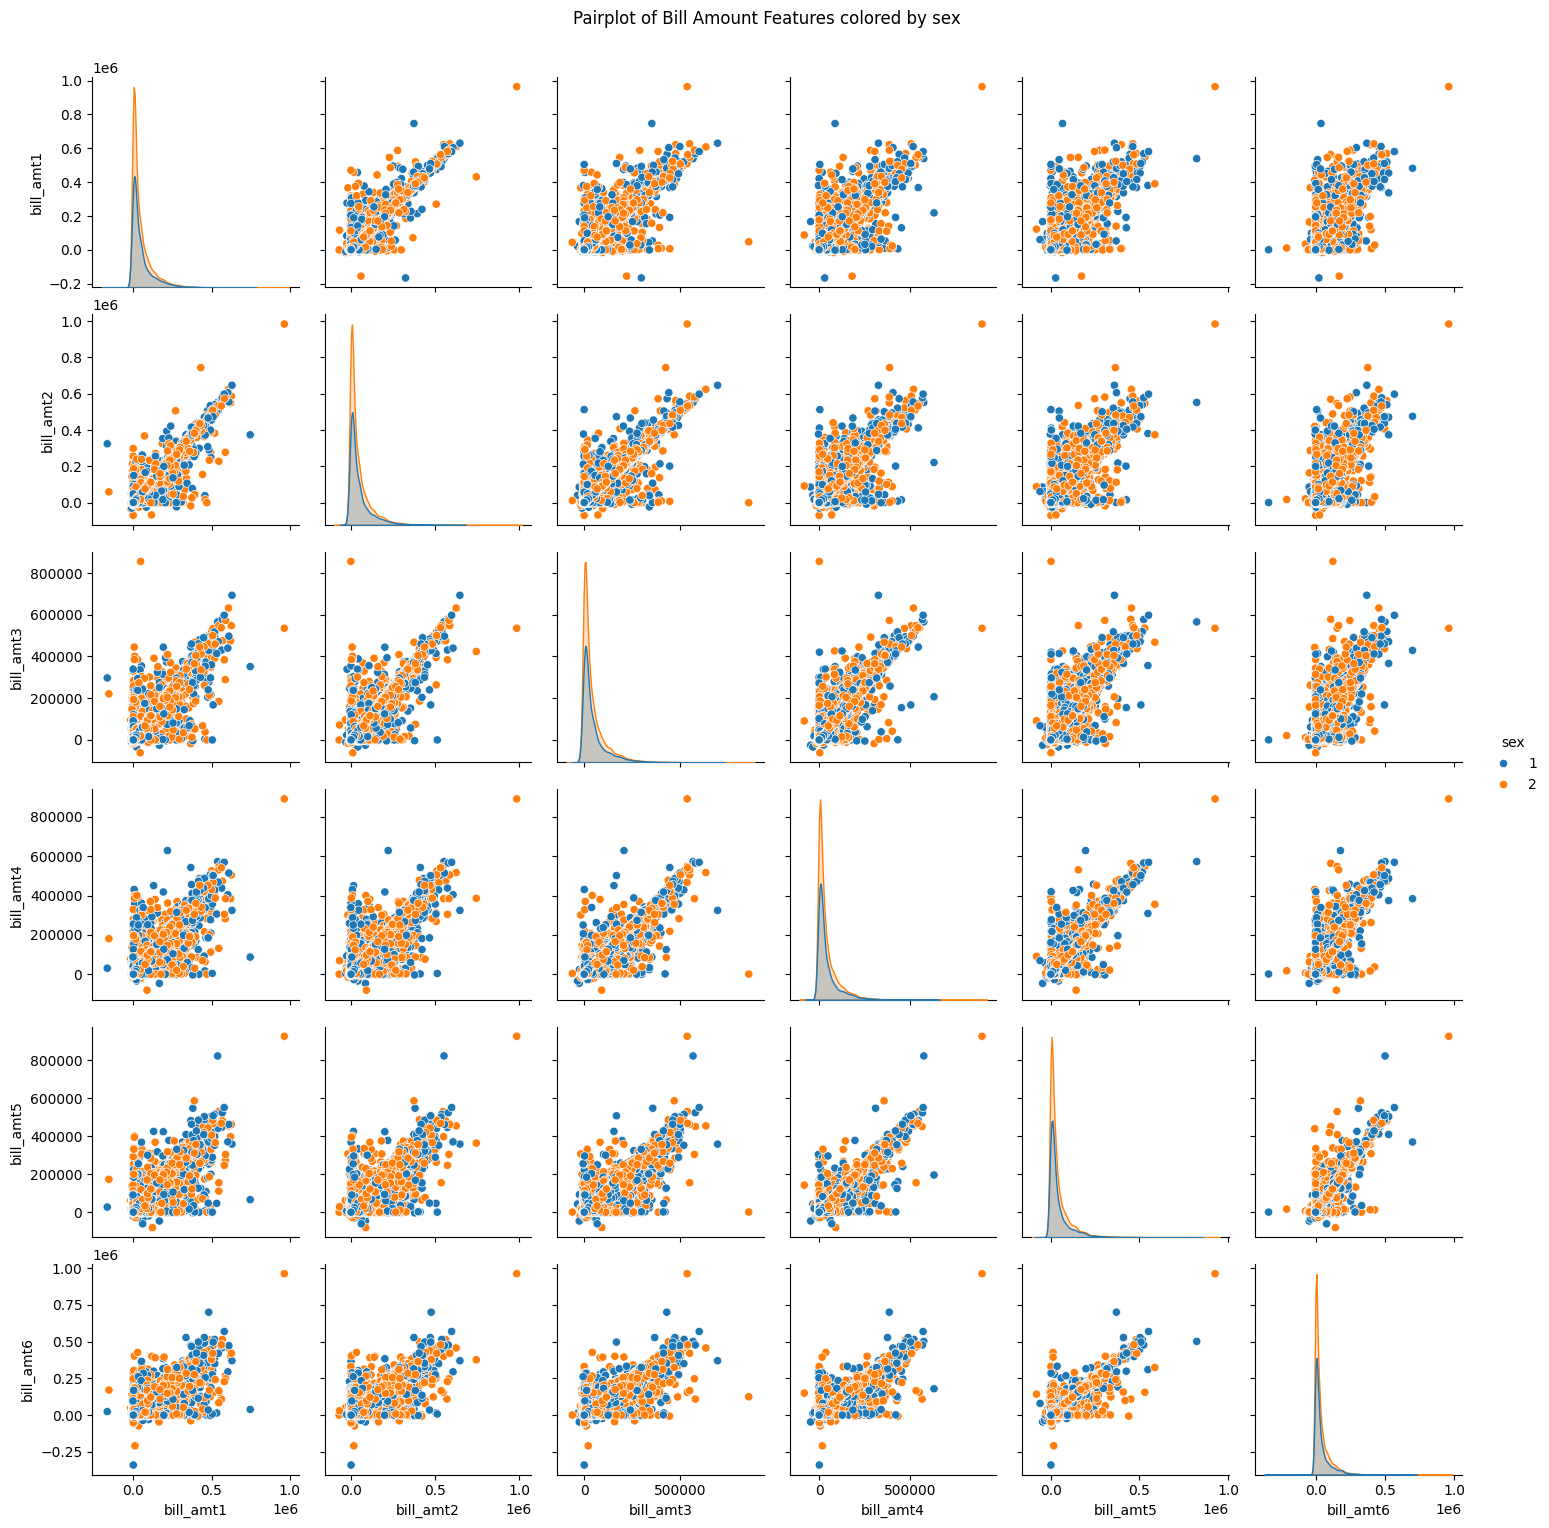

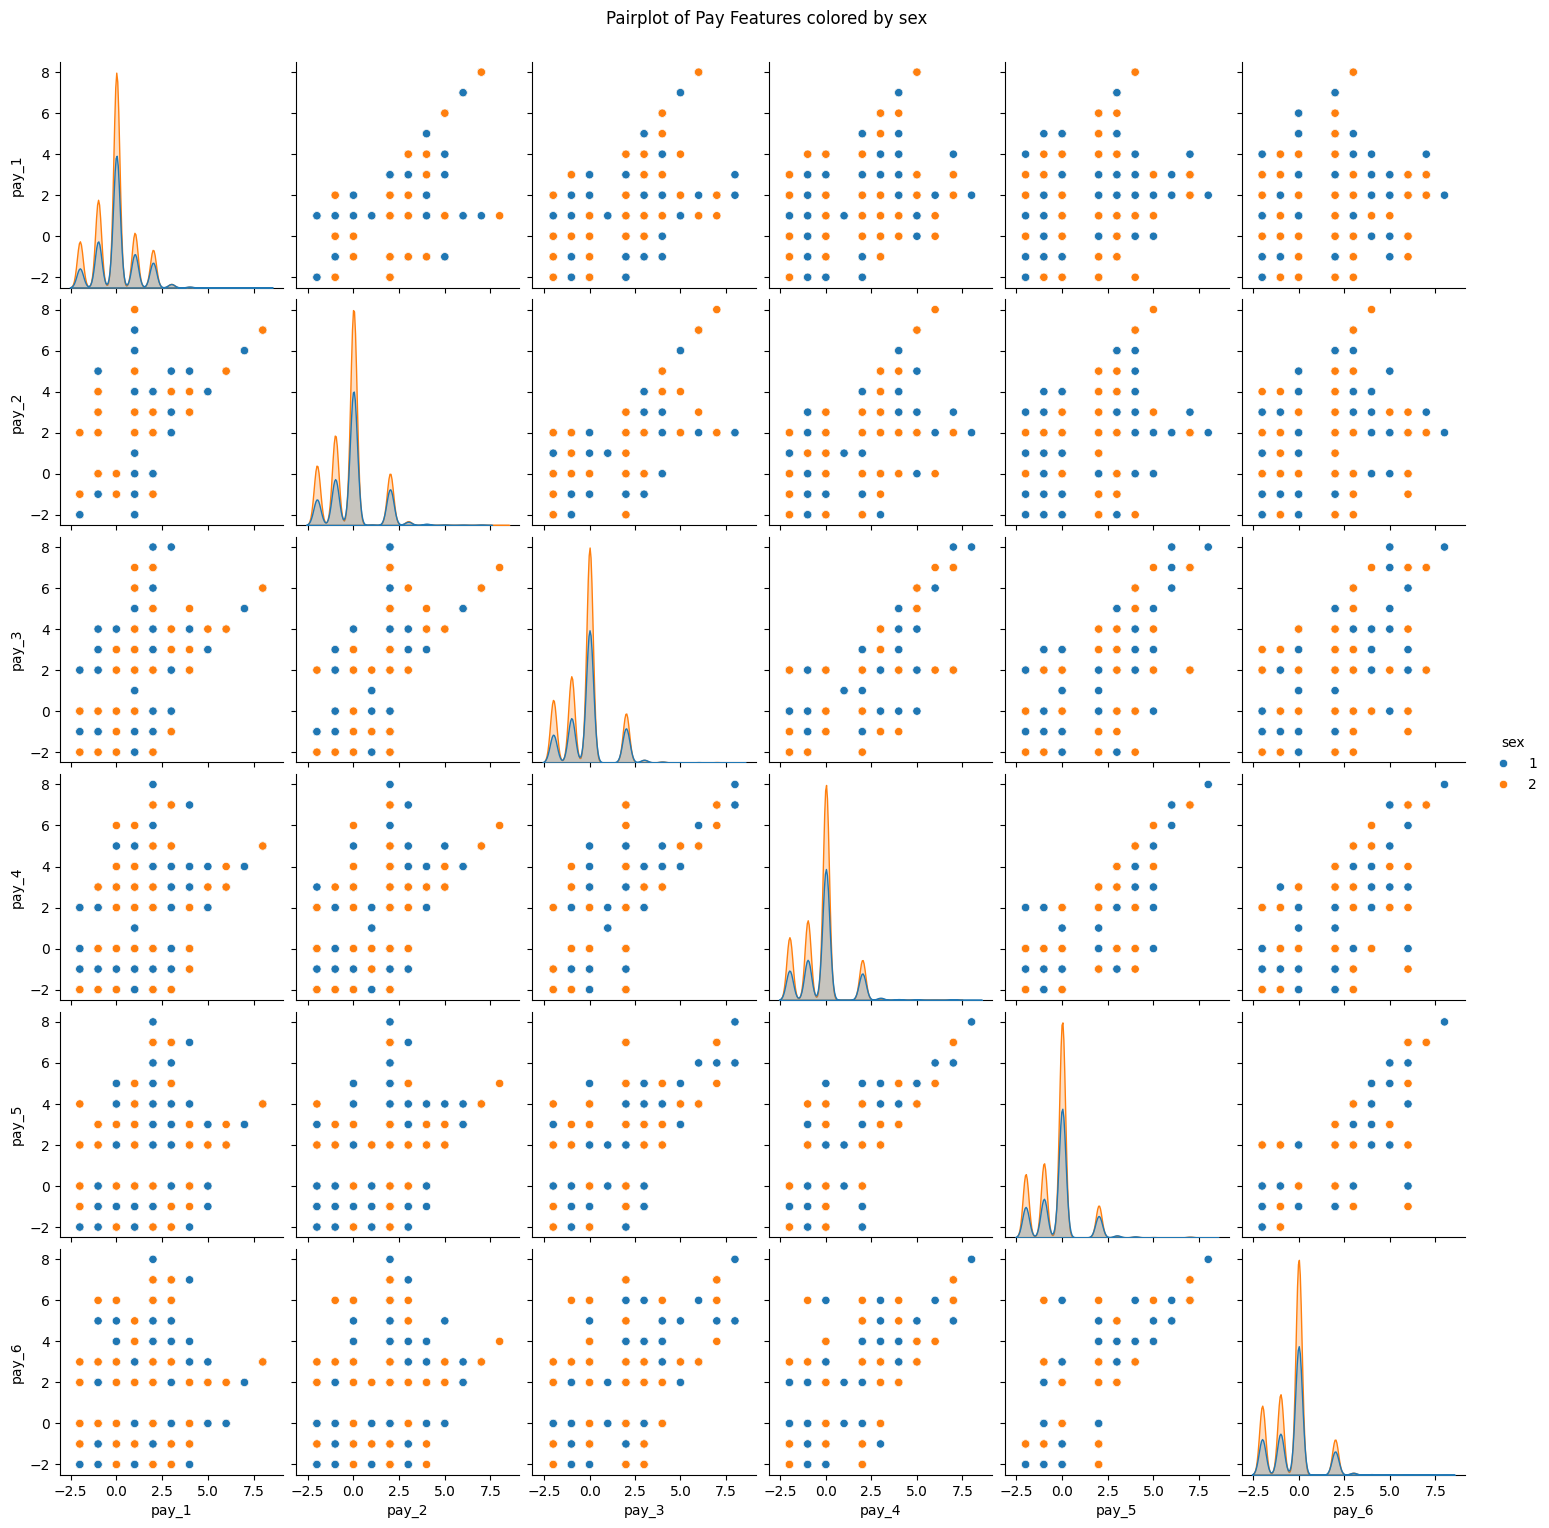

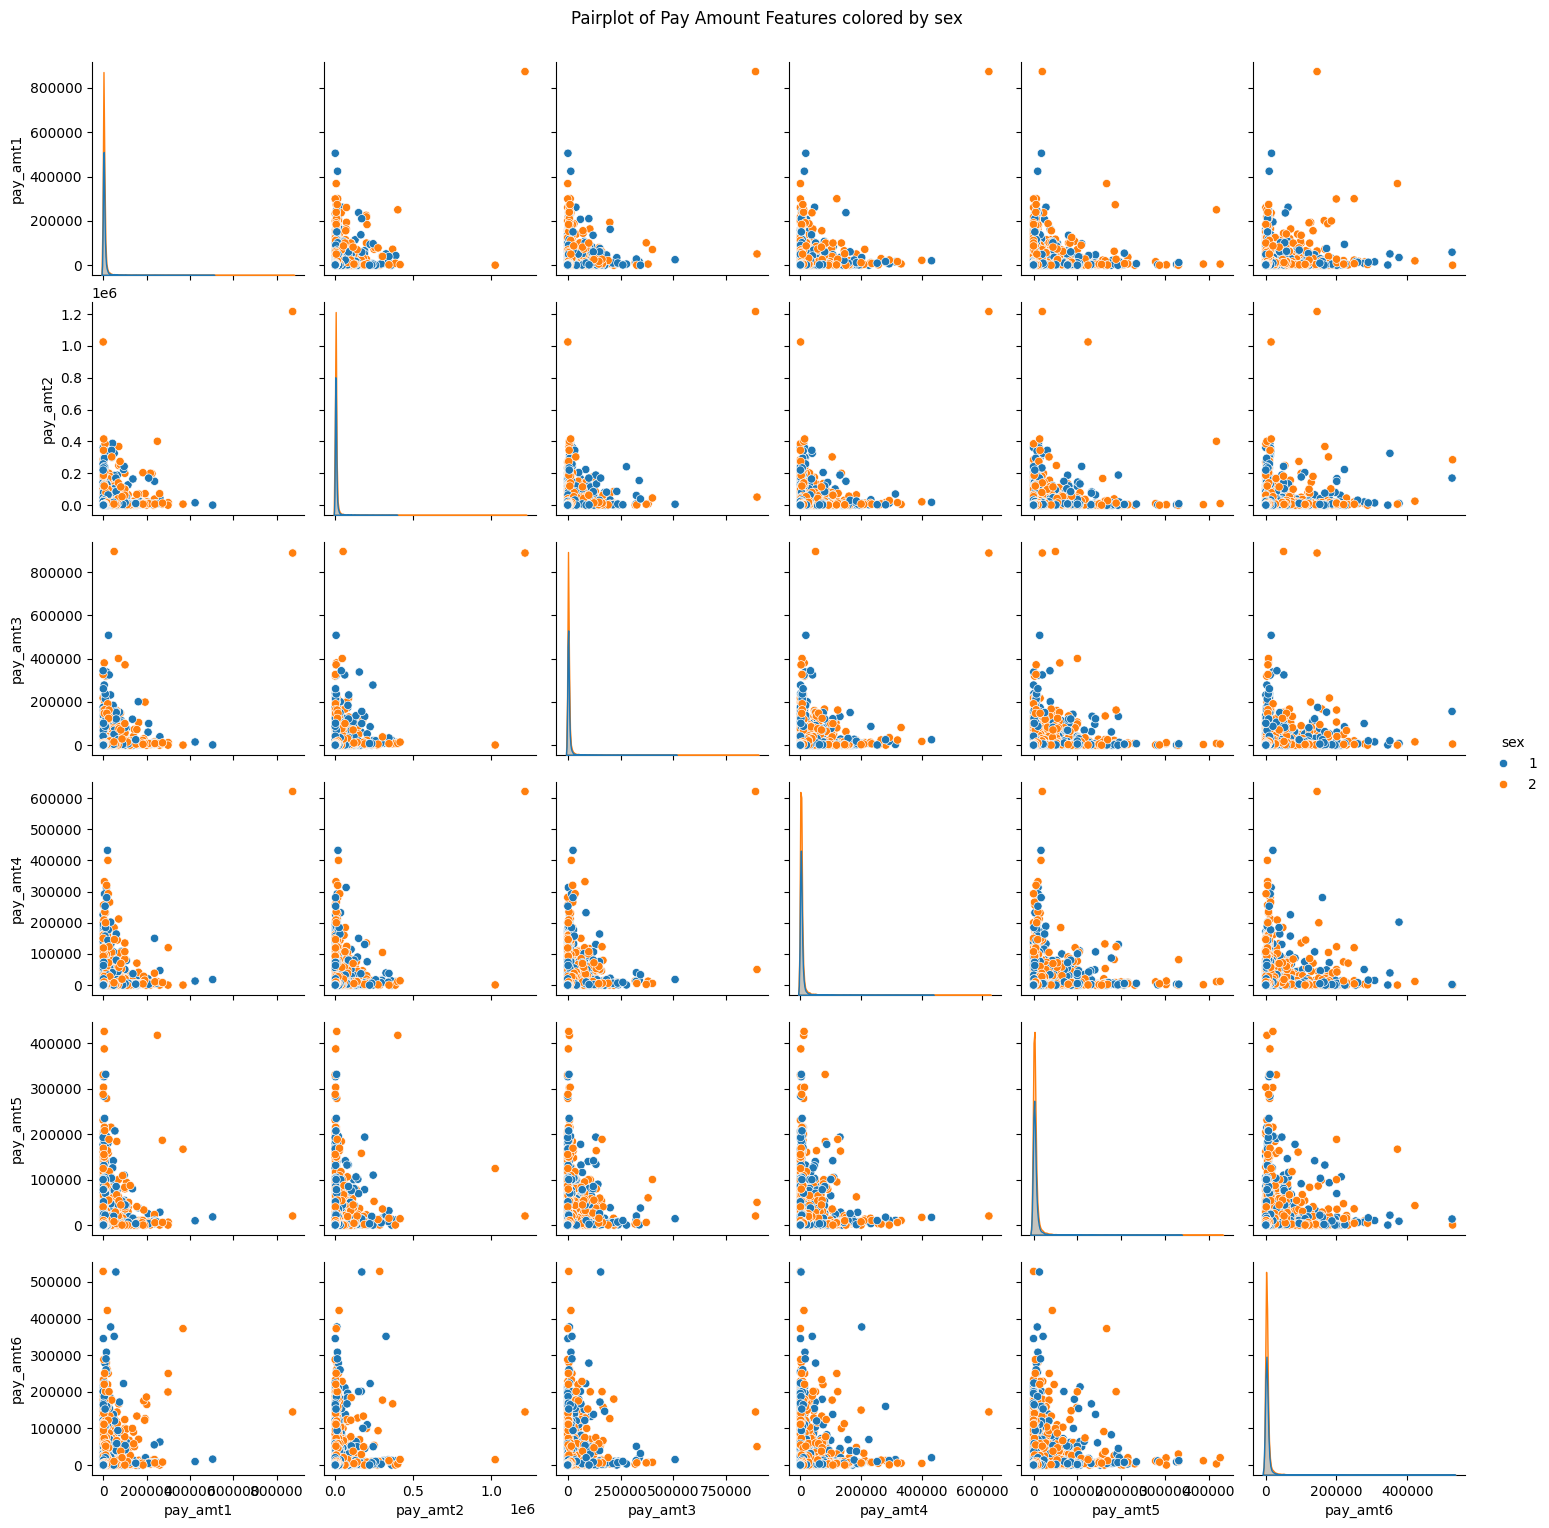

In [17]:
from loan_data_utils import plot_feature_groups

# Define groups of features
feature_groups = {
    'Bill Amount': ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6'],
    'Pay': ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'],
    'Pay Amount': ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
}

# Apply the function to your preprocessed DataFrame, coloring by 'sex' or 'marriage'
plot_feature_groups(X_train, feature_groups, hue='sex')

## Feature Engineering

In [22]:
from loan_data_feature_engineering import  RatioFeatures, BinningFeatures, SelectiveBinningFeatures, InteractionFeatures

# Convert X_train_preprocessed and X_test_preprocessed back to DataFrames
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed,
      columns=numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)))

X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed,
      columns=numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)))

# feature to bin
features_to_bin = ['bill_amt1', 'pay_amt1', 'limit_bal']  # Select features for binning

# Define feature engineering pipeline for numeric features only
feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),  # Assuming these features are present in numeric_features
    # ('binning', BinningFeatures(n_bins=5, encode='ordinal', strategy='quantile')),
    ('binning', SelectiveBinningFeatures(features_to_bin, n_bins=5, encode='ordinal', strategy='quantile')),
    ('interaction', InteractionFeatures(degree=2, interaction_only=True, include_bias=False))
])

# Apply feature engineering only to numeric features
X_train_fe_numeric = feature_engineering_pipeline.fit_transform(X_train_preprocessed_df[numeric_features])
X_test_fe_numeric = feature_engineering_pipeline.transform(X_test_preprocessed_df[numeric_features])

# Combine the engineered numeric features with the rest of the data (categorical features)
X_train_fe = pd.concat([pd.DataFrame(X_train_fe_numeric), X_train_preprocessed_df.drop(columns=numeric_features).reset_index(drop=True)], axis=1)
X_test_fe = pd.concat([pd.DataFrame(X_test_fe_numeric), X_test_preprocessed_df.drop(columns=numeric_features).reset_index(drop=True)], axis=1)

# Apply SMOTE after feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train)

# Now you can proceed with model training
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)  # or solver='liblinear'
classifier.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_fe = classifier.predict(X_test_fe)
fe_report = classification_report(y_test, y_pred_fe, output_dict=True)
print(classification_report(y_test, y_pred_fe))

# Add the current experiment report to the dictionary
experiment_results['feature_engineering'] = fe_report

# Save the updated experiment results to the JSON file
save_experiment_results(experiment_results, json_filename)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4673
           1       0.45      0.61      0.51      1327

    accuracy                           0.75      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.75      0.76      6000

Experiment results saved to classification_reports.json


Setting up the feature engineering steps in a pipeline is a best practice to ensure that you avoid data leakage and apply the transformations separately to the training and test data.

### Key Points on Data Leakage and Pipelines:

1. **Data Leakage**:
   - **What It Is**: Data leakage occurs when information from outside the training dataset is used to create the model. This can happen if data from the test set influences the training process, leading to overly optimistic performance estimates.
   - **Why It Matters**: Leakage can cause your model to perform well during development but fail when deployed in a real-world scenario.

2. **Pipelines Prevent Data Leakage**:
   - **Transformations Applied Separately**: When you use a pipeline, transformations (like scaling, encoding, or feature engineering) are applied separately to the training and test sets. This means that when fitting the pipeline, it only has access to the training data, and it applies the learned transformations to the test data without refitting.
   - **No Data Leakage**: By ensuring that each step of preprocessing and feature engineering is encapsulated in a pipeline, you prevent any possibility of accidentally allowing the test data to influence the training process.

3. **Application to Train and Test Data**:
   - **Train Data**: The pipeline is first fit on the training data, learning any necessary parameters (like the mean and standard deviation for scaling).
   - **Test Data**: The same pipeline is then applied to the test data, but it does not refit on the test data. Instead, it uses the parameters learned from the training data to transform the test data.

### Example Workflow with Pipeline:

Here’s how the process works in practice:

```python
# Feature engineering pipeline for numeric features only
feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),
    ('binning', BinningFeatures(n_bins=3, encode='ordinal', strategy='quantile')),
    ('interaction', InteractionFeatures(degree=2, interaction_only=True, include_bias=False))
])

# Fit the pipeline on the training data only
X_train_fe_numeric = feature_engineering_pipeline.fit_transform(X_train_preprocessed_df[numeric_features])

# Apply the same transformations to the test data
X_test_fe_numeric = feature_engineering_pipeline.transform(X_test_preprocessed_df[numeric_features])
```

### Why This Matters:
- **Separate Fitting**: The `.fit_transform()` method is used on the training data to learn the transformations. The `.transform()` method is used on the test data, applying the same transformations without refitting.
- **Consistency**: This approach ensures that the test data is treated in exactly the same way as the training data, but without any knowledge of the test data influencing the training process.

### Summary:
Using pipelines for feature engineering (and other preprocessing steps) is crucial for avoiding data leakage and ensuring that your model's performance estimates are accurate and generalizable to unseen data. By following this approach, you ensure that the training and test data are handled separately, with no cross-contamination.

#### Feature Engineering Script

In [19]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures

# ------ Ratio Features ------ #

class RatioFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['bill_ratio'] = X['bill_amt1'] / X['limit_bal']
        X['pay_ratio'] = X['pay_amt1'] / X['limit_bal']
        X['age_income_ratio'] = X['age'] / X['limit_bal']
        return X

# ----- Binning Features ------ #

class BinningFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=5, encode='ordinal', strategy='quantile'):
        # Explicitly store the parameters as class attributes
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)

    def fit(self, X, y=None):
        self.binner.fit(X)
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X)
        return pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.feature_names_in_])


class SelectiveBinningFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='ordinal', strategy='quantile'):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        self.other_features = None

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])
        X_binned_df = pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.features_to_bin])
        return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)

# ----- Interaction Features ------ #


class InteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, interaction_only=True, include_bias=False):
        # Explicitly store the parameters as class attributes
        self.degree = degree
        self.interaction_only = interaction_only
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)

    def fit(self, X, y=None):
        self.poly.fit(X)
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_poly = self.poly.transform(X)
        return pd.DataFrame(X_poly, columns=self.poly.get_feature_names_out(X.columns))


# ----- Plot Feature Groups ------ #

def plot_feature_groups(dataframe, feature_groups, hue):
    """
    Plot pairplots for groups of features with color coding by a categorical variable.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the features.
    feature_groups (dict): A dictionary where keys are group names and values are lists of feature names.
    hue (str): The name of the categorical column to color by.
    """
    for group_name, features in feature_groups.items():
        sns.pairplot(dataframe[features + [hue]], hue=hue, palette='magma')
        plt.suptitle(f"Pairplot of {group_name} Features colored by {hue}", y=1.02)
        plt.show()


'''

# Write the script to a file
with open("loan_data_feature_engineering.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_feature_engineering.py")

# Reload script to make functions available for use
import importlib
import loan_data_feature_engineering
importlib.reload(loan_data_feature_engineering)
from loan_data_feature_engineering import *

Script successfully written to loan_data_feature_engineering.py


When you define arguments in the `__init__` method of a class, those arguments are only available within the `__init__` method unless you explicitly attach them to the instance of the class using `self`.

Here's a breakdown:

### What Happens in `__init__`:

1. **Arguments Defined in `__init__`**:
   - When you define arguments like `degree`, `interaction_only`, and `include_bias` in the `__init__` method, they are passed when the class is instantiated.
   - However, these arguments are local to the `__init__` method unless you assign them to `self`.

2. **Assigning to `self`**:
   - By using `self.degree = degree`, you are attaching the value of `degree` to the instance of the class. This means that `self.degree` will be available throughout the instance's lifecycle and can be accessed in other methods like `fit` and `transform`.

3. **Why This is Important**:
   - Scikit-learn relies on being able to retrieve the parameters of a transformer (or any estimator) using `get_params` for things like cross-validation, pipeline construction, and hyperparameter tuning.


### Summary:
- **`self.degree = degree`**: This makes `degree` available throughout the instance, not just in `__init__`.
- **Access in Other Methods**: Other methods, like `fit` and `transform`, can then use `self.degree` (and the other parameters) to perform their operations.

This is a crucial part of working with classes in Python, especially when creating custom transformers or estimators for scikit-learn.

### Benefits of This Approach:

1. **Clarity**: By explicitly assigning attributes, it's easier to see and understand the parameters that control the behavior of each transformer.
2. **Flexibility**: If you need to reference these parameters later in the class (or outside the class), they are readily available.
3. **Debugging**: Makes it easier to debug and inspect the state of each transformer, as you can quickly check the values of `self.degree`, `self.n_bins`, etc.


#### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Classification Report Metrics   --------#

def plot_classification_report_metrics_threshold(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
